In [231]:
from choquet_integral import *
import numpy as np
import itertools
import math
import inspect
import matplotlib.pyplot as plt
import csv
import sklearn.metrics as metrics

In [116]:
from sklearn import datasets
from pyclustertend import vat, ivat
from sklearn.preprocessing import scale

In [262]:
chi = ChoquetIntegral()

data = np.random.rand(4, 25)
labels = np.amax(data, 0)
# data2 = data[::-1,:]
# labels2 = np.amin(data2,0)

# data = np.concatenate((data,data2),axis=1)
# labels = np.concatenate((labels,labels2))

# train the chi via quadratic program 
chi.train_chi(data, labels)

# print out the learned chi variables. (in this case, all 1's) 


Number Inputs :  4 ; Number Samples :  25
     pcost       dcost       gap    pres   dres
 0: -1.7801e+01 -2.5816e+01  6e+01  6e+00  1e+00
 1: -1.6937e+01 -2.4288e+01  1e+01  5e-01  9e-02
 2: -1.7171e+01 -1.9140e+01  2e+00  1e-01  2e-02
 3: -1.7781e+01 -1.8309e+01  5e-01  1e-03  2e-04
 4: -1.7937e+01 -1.8009e+01  7e-02  1e-05  2e-06
 5: -1.7967e+01 -1.7978e+01  1e-02  1e-07  2e-08
 6: -1.7971e+01 -1.7973e+01  2e-03  1e-09  2e-10
 7: -1.7972e+01 -1.7972e+01  2e-04  1e-11  2e-12
 8: -1.7972e+01 -1.7972e+01  4e-05  1e-13  1e-12
 9: -1.7972e+01 -1.7972e+01  6e-06  1e-15  3e-16
Optimal solution found.


In [207]:
print(data[:,0])
print(data[:,25])

[0.24867723 0.52339379 0.72017568 0.65452553]
[0.65452553 0.72017568 0.52339379 0.24867723]


In [263]:
n = 4
initial = []
for i in range(n):
    initial.append(i+1)
    
a = itertools.permutations(initial,4)
b = np.ndarray((math.factorial(n),n),dtype=int)
c = np.ndarray((math.factorial(n),n),dtype=float)
for i,val in enumerate(a):
    b[i] = np.asarray(val)
    
    c_build = np.ndarray(n)
    for j in range(len(b[i])):
        if j == 0:
            c_build[j] = chi.fm[str(b[i][0:1])]
        else:
            c_build[j] = (chi.fm[str(np.sort(b[i][0:j+1]))]) - (chi.fm[str(np.sort(b[i][0:j]))])

    c[i] = c_build

[9.98785074e-01 9.53800512e-04 2.22669031e-04 3.84567932e-05]
[9.98785074e-01 9.53800512e-04 2.10165788e-04 5.09600361e-05]
[9.98785074e-01 5.11524306e-04 6.64945237e-04 3.84567932e-05]
[9.98785074e-01 5.11524306e-04 6.48569222e-04 5.48328082e-05]
[9.98785074e-01 6.64091036e-04 4.99875265e-04 5.09600361e-05]
[9.98785074e-01 6.64091036e-04 4.96002493e-04 5.48328082e-05]
[9.98790861e-01 9.48012948e-04 2.22669031e-04 3.84567932e-05]
[9.98790861e-01 9.48012948e-04 2.10165788e-04 5.09600361e-05]
[9.98790861e-01 7.87284086e-04 3.83397893e-04 3.84567932e-05]
[9.98790861e-01 7.87284086e-04 3.84857601e-04 3.69970853e-05]
[9.98790861e-01 8.56682994e-04 3.01495742e-04 5.09600361e-05]
[9.98790861e-01 8.56682994e-04 3.15458693e-04 3.69970853e-05]
[9.98188643e-01 1.10795498e-03 6.64945237e-04 3.84567932e-05]
[9.98188643e-01 1.10795498e-03 6.48569222e-04 5.48328082e-05]
[9.98188643e-01 1.38950233e-03 3.83397893e-04 3.84567932e-05]
[9.98188643e-01 1.38950233e-03 3.84857601e-04 3.69970853e-05]
[9.98188

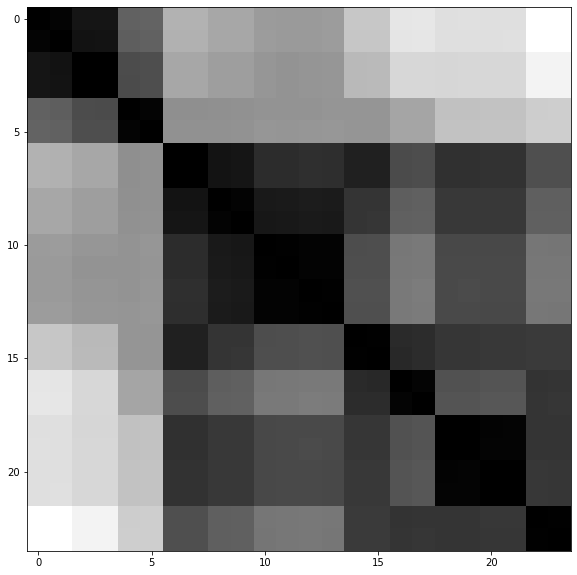

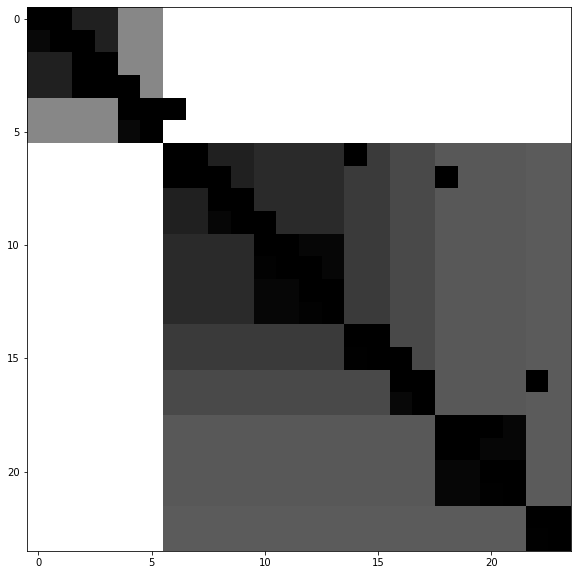

In [264]:
C = c
b = vat(C, return_ODM=True)
a = ivat(C, return_D_prim=True)



for i in range(len(c)):
    print(C[i])

In [265]:
maxdiff = 0
for row in metrics.pairwise_distances(c):
    maxdiff = max(max(row),maxdiff)
    
print(maxdiff)

np.max(c)

# metrics.pairwise_distances(b,metric='euclidean')

0.0013020161416885656


0.9989941519916303

In [266]:
with open('odm.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in b:
        writer.writerow(row)